In [2]:
# Connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.1 MB/s eta 0:00:00


In [4]:
import os
import random
import wandb
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torchvision.transforms.functional as Func  # Correct import for rotate
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [5]:
# Utils

# --------------------- Functions --------------------- #
def show_random_image(dataloader):
    # Get a random batch of images from the DataLoader
    batch = next(iter(dataloader))

    # Unpack the batch into high-resolution and low-resolution images
    hr_batch, lr_batch = batch

    # Choose a random image from the batch
    random_idx = random.randint(0, hr_batch.size(0) - 1)
    hr_image = hr_batch[random_idx]
    lr_image = lr_batch[random_idx]

    # Convert the image tensors to NumPy arrays and transpose the axes to (H, W, C)
    hr_image = hr_image.permute(1, 2, 0).numpy()
    lr_image = lr_image.permute(1, 2, 0).numpy()

    # Display the images side by side using matplotlib
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(hr_image)
    axes[0].set_title('High Resolution')
    axes[0].axis('off')  # Turn off axis labels

    axes[1].imshow(lr_image)
    axes[1].set_title('Low Resolution')
    axes[1].axis('off')  # Turn off axis labels

    plt.show()

# Define a function to sample from trainloader
def sample_trainloader(trainloader, sample_size):
    indices = random.sample(range(len(trainloader.dataset)), sample_size)
    sampled_data = torch.utils.data.Subset(trainloader.dataset, indices)
    return torch.utils.data.DataLoader(sampled_data, batch_size=trainloader.batch_size, shuffle=False)

def calculate_ssim_psnr(model, dataloader, device, flag=True):
    model.eval()  # Set the model to evaluation mode
    total_ssim_sr = 0.0
    total_psnr_sr = 0.0
    total_ssim_lr = 0.0
    total_psnr_lr = 0.0
    ssim_value_lr = 0.0
    psnr_value_lr = 0.0
    count = 0

    with torch.no_grad():
        for hr_images, lr_images in dataloader:
            # Move images to the correct device
            lr_images = lr_images.to(device)
            hr_images = hr_images.to(device)

            # Generate the super-resolved images
            sr_images = model(lr_images)

            # Move tensors back to the CPU for SSIM and PSNR calculation
            sr_images = sr_images.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to (batch, H, W, C)
            hr_images = hr_images.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to (batch, H, W, C)
            lr_images = lr_images.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to (batch, H, W, C)

            for i in range(sr_images.shape[0]):  # Iterate over the batch
                sr_img = sr_images[i]
                hr_img = hr_images[i]
                lr_img = lr_images[i]
                # lr_img_resized = resize(lr_img, (lr_img.shape[0] * 4, lr_img.shape[1] * 4),
                #         anti_aliasing=True)

                # Calculate SSIM and PSNR for SR images
                ssim_value_sr = ssim(hr_img, sr_img, data_range=sr_img.max() - sr_img.min(), channel_axis=-1)
                psnr_value_sr = psnr(hr_img, sr_img, data_range=sr_img.max() - sr_img.min())

                total_ssim_sr += ssim_value_sr
                total_psnr_sr += psnr_value_sr

                # Calculate SSIM and PSNR for LR images
                if flag:
                  ssim_value_lr = ssim(hr_img, lr_img, data_range=lr_img.max() - lr_img.min(), channel_axis=-1)
                  psnr_value_lr = psnr(hr_img, lr_img, data_range=lr_img.max() - lr_img.min())

                  total_ssim_lr += ssim_value_lr
                  total_psnr_lr += psnr_value_lr


                count += 1

    # Calculate average SSIM and PSNR
    avg_ssim_sr = total_ssim_sr / count
    avg_psnr_sr = total_psnr_sr / count
    avg_ssim_lr = total_ssim_lr / count
    avg_psnr_lr = total_psnr_lr / count

    return avg_ssim_sr, avg_psnr_sr, avg_ssim_lr, avg_psnr_lr

def calculate_ssim_psnr_for_single_image(hr_image, lr_image, sr_image):
    # Remove the batch dimension if batch_size is 1
    if hr_image.ndim == 4 and hr_image.shape[0] == 1:
        hr_image = hr_image.squeeze(0)  # Convert from (1, C, H, W) to (C, H, W)
    if lr_image.ndim == 4 and lr_image.shape[0] == 1:
        lr_image = lr_image.squeeze(0)
    if sr_image.ndim == 4 and sr_image.shape[0] == 1:
        sr_image = sr_image.squeeze(0)

    # Convert tensors to numpy arrays and rearrange to (H, W, C) if necessary
    if isinstance(hr_image, torch.Tensor):
        hr_image = hr_image.cpu().numpy()
    if isinstance(lr_image, torch.Tensor):
        lr_image = lr_image.cpu().numpy()
    if isinstance(sr_image, torch.Tensor):
        sr_image = sr_image.cpu().numpy()

    # Check if the images are in (C, H, W) format, if so, transpose to (H, W, C)
    if hr_image.shape[0] == 3:  # Assuming color images
        hr_image = hr_image.transpose(1, 2, 0)  # Convert to (H, W, C)
    if lr_image.shape[0] == 3:
        lr_image = lr_image.transpose(1, 2, 0)
    if sr_image.shape[0] == 3:
        sr_image = sr_image.transpose(1, 2, 0)

    # Calculate SSIM and PSNR for SR images
    ssim_sr = ssim(hr_image, sr_image, data_range=sr_image.max() - sr_image.min(), channel_axis=-1)
    psnr_sr = psnr(hr_image, sr_image, data_range=sr_image.max() - sr_image.min())

    # Calculate SSIM and PSNR for LR images
    ssim_lr = ssim(hr_image, lr_image, data_range=lr_image.max() - lr_image.min(), channel_axis=-1)
    psnr_lr = psnr(hr_image, lr_image, data_range=lr_image.max() - lr_image.min())

    return ssim_sr, psnr_sr, ssim_lr, psnr_lr

def calculate_val_loss(model, validloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    count = 0

    with torch.no_grad():
        for hr_images, lr_images in validloader:
            # Move images to the correct device
            lr_images = lr_images.to(device)
            hr_images = hr_images.to(device)

            # Generate the super-resolved images
            sr_images = model(lr_images)

            # Calculate the loss
            loss = criterion(sr_images, hr_images)
            total_loss += loss.item() * lr_images.size(0)
            count += lr_images.size(0)

    # Calculate the average loss
    avg_loss = total_loss / count

    return avg_loss


# -------------- Models -----------------

class SmallUNet_4X(nn.Module):  # Updated to 4X
    def __init__(self):
        super(SmallUNet_4X, self).__init__()

        # Downsampling path (Encoder)
        self.encoder1 = self.conv_block(3, 32)
        self.encoder2 = self.conv_block(32, 64)
        self.encoder3 = self.conv_block(64, 128)
        self.encoder4 = self.conv_block(128, 256)
        self.encoder5 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Upsampling path (Decoder)
        self.upconv5 = self.upconv(1024, 512)
        self.decoder5 = self.conv_block(1024, 512)
        self.upconv4 = self.upconv(512, 256)
        self.decoder4 = self.conv_block(512, 256)
        self.upconv3 = self.upconv(256, 128)
        self.decoder3 = self.conv_block(256, 128)
        self.upconv2 = self.upconv(128, 64)
        self.decoder2 = self.conv_block(128, 64)
        self.upconv1 = self.upconv(64, 32)
        self.decoder1 = self.conv_block(64, 32)

        # Final output layer of the U-Net (256x256 output)
        self.final_conv_unet = nn.Conv2d(32, 3, kernel_size=1)

        # Additional upsampling layers to achieve 512x512 output
        self.upconv_extra1 = self.upconv(32, 16)  # Upsample from 128x128 to 256x256
        self.decoder_extra1 = self.conv_block(16, 16)

        # Additional upsampling layer for 512x512 output
        self.upconv_extra2 = self.upconv(16, 8)  # Upsample from 256x256 to 512x512
        self.decoder_extra2 = self.conv_block(8, 8)

        # Final output layer to match the number of output channels
        self.final_conv = nn.Conv2d(8, 3, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Downsampling
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))
        enc5 = self.encoder5(F.max_pool2d(enc4, 2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc5, 2))

        # Upsampling
        dec5 = self.upconv5(bottleneck)
        dec5 = torch.cat((dec5, enc5), dim=1)
        dec5 = self.decoder5(dec5)

        dec4 = self.upconv4(dec5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        # Final U-Net output (256x256)
        out_unet = self.final_conv_unet(dec1)

        # # Additional upsampling to 256x256
        # up1 = self.upconv_extra1(out_unet)
        # up1 = self.decoder_extra1(up1)

        # # Additional upsampling to 512x512
        # up2 = self.upconv_extra2(up1)
        # up2 = self.decoder_extra2(up2)

        # # Final output layer
        # out = self.final_conv(up2)

        # Apply ReLU to ensure non-negative pixel values
        #out = F.relu(out_unet)

        return out_unet


# -------------------- Dataclass --------------------
class DIV2KDataset512(Dataset):
    def __init__(self, image_dir, scale=2, transform=None):
        self.image_dir = image_dir
        self.scale = scale
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        hr_image = Image.open(img_path).convert("RGB")

        # Resize the high-resolution image to 512x512
        #hr_image = hr_image.resize((512, 512), Image.BICUBIC)

        # Create the low-resolution image by further downscaling the 512x512 HR image
        lr_image = hr_image.resize((512 // self.scale, 512 // self.scale), Image.BICUBIC)
        lr_image = lr_image.resize((512, 512), Image.BICUBIC)

        # Apply the same transformation to both HR and LR images
        if self.transform:
            seed = torch.seed()  # Get a random seed
            random.seed(seed)  # Apply the seed before transforming HR
            torch.manual_seed(seed)  # Apply the seed before transforming HR
            hr_image = self.transform(hr_image)

            random.seed(seed)  # Reset the seed before transforming LR
            torch.manual_seed(seed)  # Reset the seed before transforming LR
            lr_image = self.transform(lr_image)

        return hr_image, lr_image

In [6]:
# connect to wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

wandb: Currently logged in as: alonhel (eebgu). Use `wandb login --relogin` to force relogin


Number of training batches: 236
Number of validation batches: 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


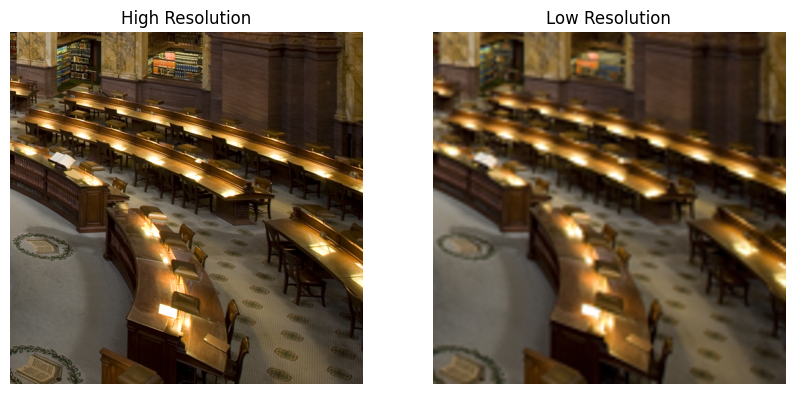

Device is:  cuda


100%|██████████| 236/236 [03:23<00:00,  1.16it/s]


Epoch 1/60, Train Loss: 0.0456, Learning Rate: 0.000100
Epoch 1/60, Valid Loss: 0.0084
Validation SSIM (SR): 0.6466, PSNR (SR): 22.3059
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:42<00:00,  1.45it/s]


Epoch 2/60, Train Loss: 0.0053, Learning Rate: 0.000100
Epoch 2/60, Valid Loss: 0.0057
Validation SSIM (SR): 0.7062, PSNR (SR): 25.4216
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:43<00:00,  1.44it/s]


Epoch 3/60, Train Loss: 0.0043, Learning Rate: 0.000100
Epoch 3/60, Valid Loss: 0.0053
Validation SSIM (SR): 0.7199, PSNR (SR): 25.9212
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 4/60, Train Loss: 0.0040, Learning Rate: 0.000100
Epoch 4/60, Valid Loss: 0.0052
Validation SSIM (SR): 0.7245, PSNR (SR): 25.6046
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:43<00:00,  1.44it/s]


Epoch 5/60, Train Loss: 0.0039, Learning Rate: 0.000100
Epoch 5/60, Valid Loss: 0.0049
Validation SSIM (SR): 0.7371, PSNR (SR): 26.2445
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:43<00:00,  1.44it/s]


Epoch 6/60, Train Loss: 0.0038, Learning Rate: 0.000100
Epoch 6/60, Valid Loss: 0.0049
Validation SSIM (SR): 0.7377, PSNR (SR): 26.1329
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.43it/s]


Epoch 7/60, Train Loss: 0.0038, Learning Rate: 0.000100
Epoch 7/60, Valid Loss: 0.0051
Validation SSIM (SR): 0.7329, PSNR (SR): 25.5401
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:43<00:00,  1.44it/s]


Epoch 8/60, Train Loss: 0.0038, Learning Rate: 0.000100
Epoch 8/60, Valid Loss: 0.0048
Validation SSIM (SR): 0.7427, PSNR (SR): 26.3752
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 9/60, Train Loss: 0.0037, Learning Rate: 0.000100
Epoch 9/60, Valid Loss: 0.0047
Validation SSIM (SR): 0.7478, PSNR (SR): 26.5559
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:43<00:00,  1.44it/s]


Epoch 10/60, Train Loss: 0.0037, Learning Rate: 0.000100
Epoch 10/60, Valid Loss: 0.0047
Validation SSIM (SR): 0.7472, PSNR (SR): 26.4678
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.43it/s]


Epoch 11/60, Train Loss: 0.0037, Learning Rate: 0.000100
Epoch 11/60, Valid Loss: 0.0046
Validation SSIM (SR): 0.7514, PSNR (SR): 26.7212
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 12/60, Train Loss: 0.0036, Learning Rate: 0.000100
Epoch 12/60, Valid Loss: 0.0046
Validation SSIM (SR): 0.7523, PSNR (SR): 26.7266
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.43it/s]


Epoch 13/60, Train Loss: 0.0036, Learning Rate: 0.000100
Epoch 13/60, Valid Loss: 0.0047
Validation SSIM (SR): 0.7485, PSNR (SR): 26.2370
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:45<00:00,  1.43it/s]


Epoch 14/60, Train Loss: 0.0036, Learning Rate: 0.000100
Epoch 14/60, Valid Loss: 0.0046
Validation SSIM (SR): 0.7534, PSNR (SR): 26.6749
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 15/60, Train Loss: 0.0036, Learning Rate: 0.000100
Epoch 15/60, Valid Loss: 0.0045
Validation SSIM (SR): 0.7521, PSNR (SR): 26.6748
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:43<00:00,  1.44it/s]


Epoch 16/60, Train Loss: 0.0035, Learning Rate: 0.000100
Epoch 16/60, Valid Loss: 0.0045
Validation SSIM (SR): 0.7574, PSNR (SR): 26.8384
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.43it/s]


Epoch 17/60, Train Loss: 0.0035, Learning Rate: 0.000100
Epoch 17/60, Valid Loss: 0.0045
Validation SSIM (SR): 0.7583, PSNR (SR): 26.8608
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.43it/s]


Epoch 18/60, Train Loss: 0.0035, Learning Rate: 0.000100
Epoch 18/60, Valid Loss: 0.0045
Validation SSIM (SR): 0.7583, PSNR (SR): 26.8075
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.43it/s]


Epoch 19/60, Train Loss: 0.0035, Learning Rate: 0.000100
Epoch 19/60, Valid Loss: 0.0048
Validation SSIM (SR): 0.7574, PSNR (SR): 26.0770
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:45<00:00,  1.43it/s]


Epoch 20/60, Train Loss: 0.0035, Learning Rate: 0.000100
Epoch 20/60, Valid Loss: 0.0053
Validation SSIM (SR): 0.7435, PSNR (SR): 24.8312
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.43it/s]


Epoch 21/60, Train Loss: 0.0035, Learning Rate: 0.000100
Epoch 21/60, Valid Loss: 0.0044
Validation SSIM (SR): 0.7603, PSNR (SR): 26.8637
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 22/60, Train Loss: 0.0034, Learning Rate: 0.000100
Epoch 22/60, Valid Loss: 0.0044
Validation SSIM (SR): 0.7622, PSNR (SR): 26.9218
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:45<00:00,  1.43it/s]


Epoch 23/60, Train Loss: 0.0034, Learning Rate: 0.000100
Epoch 23/60, Valid Loss: 0.0044
Validation SSIM (SR): 0.7638, PSNR (SR): 27.0195
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 24/60, Train Loss: 0.0034, Learning Rate: 0.000100
Epoch 24/60, Valid Loss: 0.0043
Validation SSIM (SR): 0.7623, PSNR (SR): 26.8781
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:45<00:00,  1.43it/s]


Epoch 25/60, Train Loss: 0.0034, Learning Rate: 0.000100
Epoch 25/60, Valid Loss: 0.0043
Validation SSIM (SR): 0.7646, PSNR (SR): 26.9914
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.43it/s]


Epoch 26/60, Train Loss: 0.0033, Learning Rate: 0.000100
Epoch 26/60, Valid Loss: 0.0043
Validation SSIM (SR): 0.7666, PSNR (SR): 27.0827
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 27/60, Train Loss: 0.0033, Learning Rate: 0.000100
Epoch 27/60, Valid Loss: 0.0043
Validation SSIM (SR): 0.7653, PSNR (SR): 26.9774
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 28/60, Train Loss: 0.0033, Learning Rate: 0.000100
Epoch 28/60, Valid Loss: 0.0043
Validation SSIM (SR): 0.7674, PSNR (SR): 26.7988
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 29/60, Train Loss: 0.0033, Learning Rate: 0.000100
Epoch 29/60, Valid Loss: 0.0042
Validation SSIM (SR): 0.7670, PSNR (SR): 27.0031
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:45<00:00,  1.43it/s]


Epoch 30/60, Train Loss: 0.0033, Learning Rate: 0.000100
Epoch 30/60, Valid Loss: 0.0042
Validation SSIM (SR): 0.7693, PSNR (SR): 27.1037
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.43it/s]


Epoch 31/60, Train Loss: 0.0033, Learning Rate: 0.000100
Epoch 31/60, Valid Loss: 0.0042
Validation SSIM (SR): 0.7699, PSNR (SR): 27.1296
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 32/60, Train Loss: 0.0033, Learning Rate: 0.000100
Epoch 32/60, Valid Loss: 0.0042
Validation SSIM (SR): 0.7707, PSNR (SR): 27.0497
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.43it/s]


Epoch 33/60, Train Loss: 0.0033, Learning Rate: 0.000100
Epoch 33/60, Valid Loss: 0.0042
Validation SSIM (SR): 0.7722, PSNR (SR): 27.2242
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 34/60, Train Loss: 0.0032, Learning Rate: 0.000100
Epoch 34/60, Valid Loss: 0.0042
Validation SSIM (SR): 0.7714, PSNR (SR): 27.1183
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:43<00:00,  1.44it/s]


Epoch 35/60, Train Loss: 0.0032, Learning Rate: 0.000100
Epoch 35/60, Valid Loss: 0.0042
Validation SSIM (SR): 0.7701, PSNR (SR): 27.0361
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 36/60, Train Loss: 0.0032, Learning Rate: 0.000100
Epoch 36/60, Valid Loss: 0.0041
Validation SSIM (SR): 0.7740, PSNR (SR): 27.2351
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:43<00:00,  1.44it/s]


Epoch 37/60, Train Loss: 0.0032, Learning Rate: 0.000100
Epoch 37/60, Valid Loss: 0.0041
Validation SSIM (SR): 0.7734, PSNR (SR): 27.1919
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.43it/s]


Epoch 38/60, Train Loss: 0.0032, Learning Rate: 0.000100
Epoch 38/60, Valid Loss: 0.0041
Validation SSIM (SR): 0.7771, PSNR (SR): 27.3788
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 39/60, Train Loss: 0.0032, Learning Rate: 0.000100
Epoch 39/60, Valid Loss: 0.0041
Validation SSIM (SR): 0.7764, PSNR (SR): 27.3424
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.43it/s]


Epoch 40/60, Train Loss: 0.0032, Learning Rate: 0.000100
Epoch 40/60, Valid Loss: 0.0041
Validation SSIM (SR): 0.7747, PSNR (SR): 27.2192
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:43<00:00,  1.44it/s]


Epoch 41/60, Train Loss: 0.0032, Learning Rate: 0.000100
Epoch 41/60, Valid Loss: 0.0041
Validation SSIM (SR): 0.7758, PSNR (SR): 27.2141
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:43<00:00,  1.44it/s]


Epoch 42/60, Train Loss: 0.0032, Learning Rate: 0.000100
Epoch 42/60, Valid Loss: 0.0041
Validation SSIM (SR): 0.7755, PSNR (SR): 27.2584
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:43<00:00,  1.44it/s]


Epoch 43/60, Train Loss: 0.0032, Learning Rate: 0.000100
Epoch 43/60, Valid Loss: 0.0040
Validation SSIM (SR): 0.7776, PSNR (SR): 27.2880
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:43<00:00,  1.44it/s]


Epoch 44/60, Train Loss: 0.0032, Learning Rate: 0.000100
Epoch 44/60, Valid Loss: 0.0041
Validation SSIM (SR): 0.7799, PSNR (SR): 27.4884
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 45/60, Train Loss: 0.0031, Learning Rate: 0.000010
Epoch 45/60, Valid Loss: 0.0040
Validation SSIM (SR): 0.7761, PSNR (SR): 27.1881
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:43<00:00,  1.44it/s]


Epoch 46/60, Train Loss: 0.0031, Learning Rate: 0.000010
Epoch 46/60, Valid Loss: 0.0040
Validation SSIM (SR): 0.7782, PSNR (SR): 27.3102
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:43<00:00,  1.44it/s]


Epoch 47/60, Train Loss: 0.0031, Learning Rate: 0.000010
Epoch 47/60, Valid Loss: 0.0040
Validation SSIM (SR): 0.7782, PSNR (SR): 27.3121
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:43<00:00,  1.44it/s]


Epoch 48/60, Train Loss: 0.0031, Learning Rate: 0.000010
Epoch 48/60, Valid Loss: 0.0040
Validation SSIM (SR): 0.7784, PSNR (SR): 27.3276
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.43it/s]


Epoch 49/60, Train Loss: 0.0031, Learning Rate: 0.000010
Epoch 49/60, Valid Loss: 0.0040
Validation SSIM (SR): 0.7784, PSNR (SR): 27.3163
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 50/60, Train Loss: 0.0031, Learning Rate: 0.000010
Epoch 50/60, Valid Loss: 0.0040
Validation SSIM (SR): 0.7793, PSNR (SR): 27.3631
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 51/60, Train Loss: 0.0031, Learning Rate: 0.000010
Epoch 51/60, Valid Loss: 0.0040
Validation SSIM (SR): 0.7785, PSNR (SR): 27.3319
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:43<00:00,  1.44it/s]


Epoch 52/60, Train Loss: 0.0031, Learning Rate: 0.000010
Epoch 52/60, Valid Loss: 0.0040
Validation SSIM (SR): 0.7788, PSNR (SR): 27.3492
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:43<00:00,  1.44it/s]


Epoch 53/60, Train Loss: 0.0031, Learning Rate: 0.000010
Epoch 53/60, Valid Loss: 0.0040
Validation SSIM (SR): 0.7794, PSNR (SR): 27.3690
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.43it/s]


Epoch 54/60, Train Loss: 0.0031, Learning Rate: 0.000010
Epoch 54/60, Valid Loss: 0.0040
Validation SSIM (SR): 0.7790, PSNR (SR): 27.3443
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:43<00:00,  1.44it/s]


Epoch 55/60, Train Loss: 0.0031, Learning Rate: 0.000010
Epoch 55/60, Valid Loss: 0.0040
Validation SSIM (SR): 0.7793, PSNR (SR): 27.3588
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 56/60, Train Loss: 0.0031, Learning Rate: 0.000010
Epoch 56/60, Valid Loss: 0.0040
Validation SSIM (SR): 0.7793, PSNR (SR): 27.3463
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 57/60, Train Loss: 0.0031, Learning Rate: 0.000010
Epoch 57/60, Valid Loss: 0.0040
Validation SSIM (SR): 0.7789, PSNR (SR): 27.3386
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:43<00:00,  1.44it/s]


Epoch 58/60, Train Loss: 0.0031, Learning Rate: 0.000010
Epoch 58/60, Valid Loss: 0.0040
Validation SSIM (SR): 0.7788, PSNR (SR): 27.3251
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 59/60, Train Loss: 0.0031, Learning Rate: 0.000010
Epoch 59/60, Valid Loss: 0.0040
Validation SSIM (SR): 0.7783, PSNR (SR): 27.3061
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


100%|██████████| 236/236 [02:44<00:00,  1.44it/s]


Epoch 60/60, Train Loss: 0.0031, Learning Rate: 0.000010
Epoch 60/60, Valid Loss: 0.0040
Validation SSIM (SR): 0.7795, PSNR (SR): 27.3428
Validation SSIM (LR): 0.7223, PSNR (LR): 25.2693


avg_psnr_lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_psnr_sr,▁▅▅▆▅▆▇▇▆▇▇▇▆▄▇▇▇▇▇▇█▇█▇████████████████
avg_ssim_lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_ssim_sr,▁▄▅▆▆▆▆▇▆▇▇▇▇▆▇▇▇▇▇▇▇██▇████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_val_loss,█▄▃▂▃▂▂▂▂▂▂▂▂▃▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,██████████████████████████████▁▁▁▁▁▁▁▁▁▁
train_avg_psnr_lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_avg_psnr_sr,▁▆▅▆▅▆▇▆▆▇▇▇▆▄▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇█
train_avg_ssim_lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


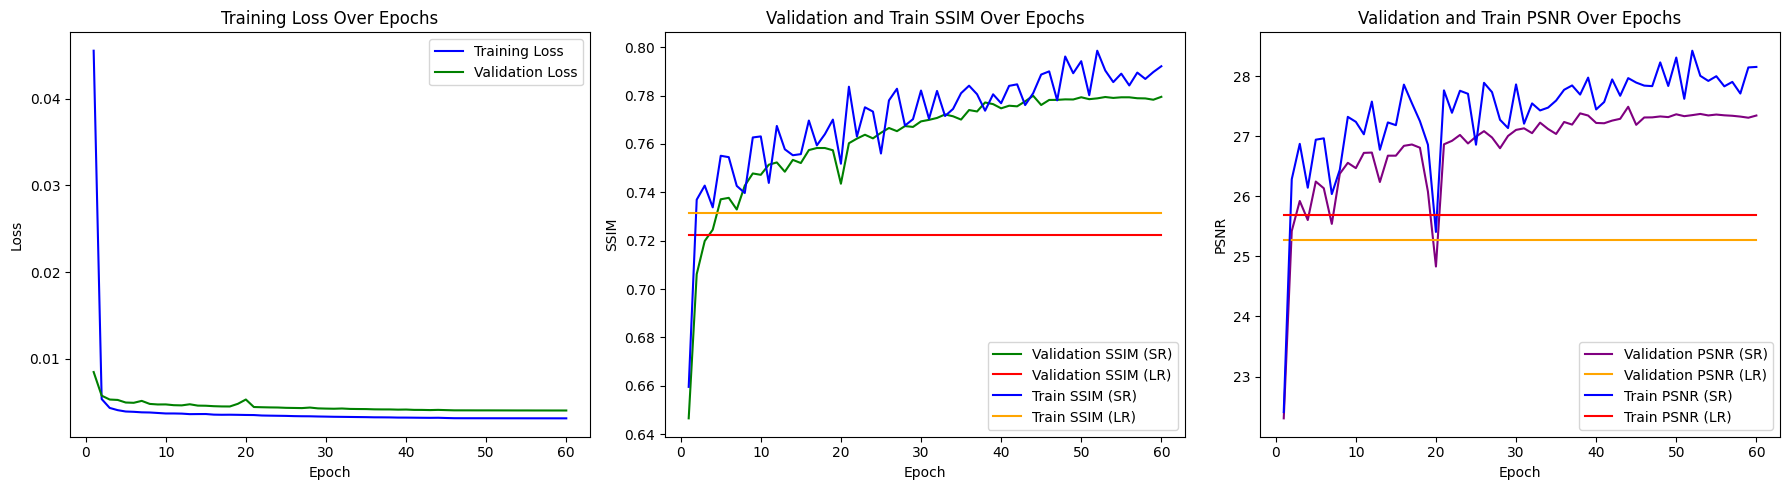

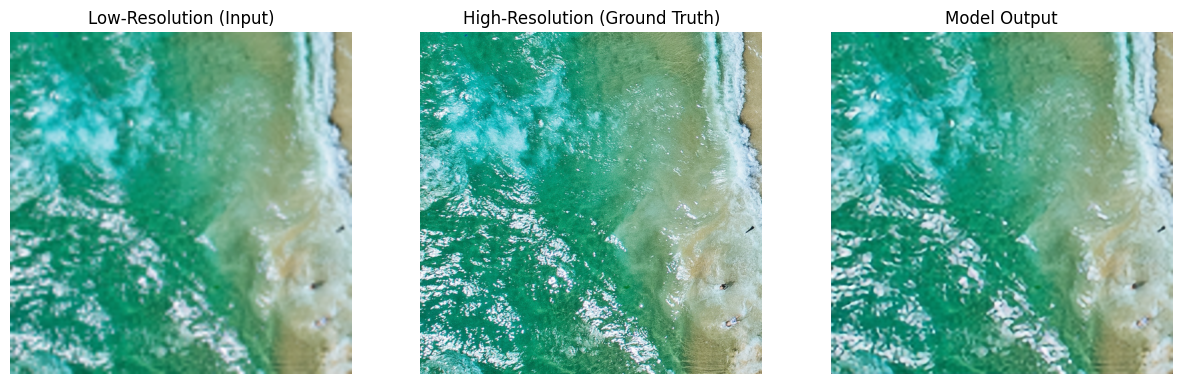

In [7]:
def train(model, trainloader, validloader, criterion, optimizer, num_epochs):
    model.train()

    # Learning rate scheduler
    scheduler = StepLR(optimizer, step_size=45, gamma=0.1)

    # Lists to store metrics
    loss_list = []
    val_loss_list = []
    ssim_sr_list = []
    psnr_sr_list = []
    ssim_lr_list = []
    psnr_lr_list = []
    val_psnr_lr_value = 0.0
    val_ssim_lr_value = 0.0
    train_psnr_lr_value = 0.0
    train_ssim_lr_value = 0.0
    train_ssim_sr_list = []
    train_psnr_sr_list = []
    train_ssim_lr_list = []
    train_psnr_lr_list = []
    lr_flag = True
    max_valid_psnr = 26.5

    for epoch in range(num_epochs):
        running_loss = 0.0

        for hr_images, lr_images in tqdm(trainloader):
            # Move the data to the appropriate device (GPU or CPU)
            lr_images = lr_images.to(device)
            hr_images = hr_images.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass: Get the model output
            outputs = model(lr_images)

            # Calculate the loss
            loss = criterion(outputs, hr_images)

            # Backward pass: Compute the gradients
            loss.backward()

            # Update the weights
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item() * lr_images.size(0)

        # Step the scheduler after each epoch
        scheduler.step()


        # Compute the average loss over the epoch
        epoch_loss = running_loss / len(trainloader.dataset)
        epoch_val_loss = calculate_val_loss(model, validloader, criterion, device)
        val_loss_list.append(epoch_val_loss)
        loss_list.append(epoch_loss)

        # Evaluate the model on the validation set
        avg_ssim_sr, avg_psnr_sr, avg_ssim_lr, avg_psnr_lr = calculate_ssim_psnr(model, validloader, device, lr_flag)
        if lr_flag:
            val_psnr_lr_value = avg_psnr_lr
            val_ssim_lr_value = avg_ssim_lr
        if avg_psnr_sr > max_valid_psnr:
            max_valid_psnr = avg_psnr_sr
            torch.save(model.state_dict(), f'/content/drive/MyDrive/לימודים/DeepLearning/DIV2K_Cropped_DS/combined/checkpoints/combined_4X_psnr_{max_valid_psnr}_ssim_{avg_ssim_sr}.pth')
        # Evalute the model on the training set
        # Get the size of validloader
        validloader_size = len(validloader.dataset)

        # Sample the trainloader
        sampled_trainloader = sample_trainloader(trainloader, validloader_size)

        # Evaluate the model on the training set using the sampled trainloader
        avg_ssim_sr_train, avg_psnr_sr_train, avg_ssim_lr_train, avg_psnr_lr_train = calculate_ssim_psnr(model, sampled_trainloader, device, lr_flag)
        if lr_flag:
            train_psnr_lr_value = avg_psnr_lr_train
            train_ssim_lr_value = avg_ssim_lr_train

        # Append validation metrics to their respective lists
        ssim_sr_list.append(avg_ssim_sr)
        psnr_sr_list.append(avg_psnr_sr)
        ssim_lr_list.append(val_ssim_lr_value)
        psnr_lr_list.append(val_psnr_lr_value)
        train_ssim_sr_list.append(avg_ssim_sr_train)
        train_psnr_sr_list.append(avg_psnr_sr_train)
        train_ssim_lr_list.append(train_ssim_lr_value)
        train_psnr_lr_list.append(train_psnr_lr_value)

        # Log metrics to wandb
        wandb.log({
            'epoch': epoch + 1,
            'epoch_loss': epoch_loss,
            'epoch_val_loss': epoch_val_loss,
            'avg_ssim_sr': avg_ssim_sr,
            'avg_psnr_sr': avg_psnr_sr,
            'avg_ssim_lr': val_ssim_lr_value,
            'avg_psnr_lr': val_psnr_lr_value,
            'train_avg_ssim_sr': avg_ssim_sr_train,
            'train_avg_psnr_sr': avg_psnr_sr_train,
            'train_avg_ssim_lr': train_ssim_lr_value,
            'train_avg_psnr_lr': train_psnr_lr_value,
            'learning_rate': optimizer.param_groups[0]["lr"]
        })

        # Print metrics
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        print(f'Epoch {epoch+1}/{num_epochs}, Valid Loss: {epoch_val_loss:.4f}')
        print(f'Validation SSIM (SR): {avg_ssim_sr:.4f}, PSNR (SR): {avg_psnr_sr:.4f}')
        print(f'Validation SSIM (LR): {val_ssim_lr_value:.4f}, PSNR (LR): {val_psnr_lr_value:.4f}')

        # Save checkpoint every few epochs
        # if epoch % 20 == 0:
        #     torch.save(model.state_dict(), f"/content/drive/MyDrive/לימודים/DeepLearning/DIV2K_Cropped_DS/man_made_500/checkpoints/unet_model_epoch_{epoch}_loss_{epoch_loss}_avg_sr_psnr_{avg_psnr_sr}_avg_sr_ssim_{avg_ssim_sr}.pth")
        if epoch == 0:
          lr_flag = False

    # Log final results and finish the run
    wandb.finish()

    # Create a figure with 3 subplots (1 row, 3 columns)
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Plot Training Loss
    axs[0].plot(range(1, num_epochs + 1), loss_list, label='Training Loss', color='blue')
    axs[0].plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss', color='green')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training Loss Over Epochs')
    axs[0].legend()

    # Plot Validation and train SSIM for SR and LR
    axs[1].plot(range(1, num_epochs + 1), ssim_sr_list, label='Validation SSIM (SR)', color='green')
    axs[1].plot(range(1, num_epochs + 1), ssim_lr_list, label='Validation SSIM (LR)', color='red')
    axs[1].plot(range(1, num_epochs + 1), train_ssim_sr_list, label='Train SSIM (SR)', color='blue')
    axs[1].plot(range(1, num_epochs + 1), train_ssim_lr_list, label='Train SSIM (LR)', color='orange')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('SSIM')
    axs[1].set_title('Validation and Train SSIM Over Epochs')
    axs[1].legend()

    # Plot Validation and Train PSNR for SR and LR
    axs[2].plot(range(1, num_epochs + 1), psnr_sr_list, label='Validation PSNR (SR)', color='purple')
    axs[2].plot(range(1, num_epochs + 1), psnr_lr_list, label='Validation PSNR (LR)', color='orange')
    axs[2].plot(range(1, num_epochs + 1), train_psnr_sr_list, label='Train PSNR (SR)', color='blue')
    axs[2].plot(range(1, num_epochs + 1), train_psnr_lr_list, label='Train PSNR (LR)', color='red')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('PSNR')
    axs[2].set_title('Validation and Train PSNR Over Epochs')
    axs[2].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the figure to the project folder
    plt.savefig('/content/training_validation_metrics_4X_combined_mse.png')
    plt.show()

    # Save lists to a file if needed
    results = {
        'loss': loss_list,
        'ssim_sr': ssim_sr_list,
        'psnr_sr': psnr_sr_list,
        'ssim_lr': ssim_lr_list,
        'psnr_lr': psnr_lr_list,
    }
    #torch.save(results, 'training_metrics_4X_man_made_updated.pth')


# Define a function for random rotation
def random_rotation(img):
    return Func.rotate(img, random.choice([0, 90, 270]))

# --------------------- Main --------------------- #
if __name__ == '__main__':
    config = config={
        "learning_rate": 1e-4,
        "epochs": 60,
        "batch_size": 8,
        "optimizer": "Adam",
        "weight_decay": 1e-6,
        "scale": 4
    }
    wandb.init(project="super_resolution_project", name=f"combined_{config['epochs']}_epochs_mse",config=config)

    # Set the random seed for reproducibility
    random.seed(42)
    # Define the transformation: Resize the image to 512x512
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Updated transformation pipeline
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally with a probability of 0.5
        transforms.Lambda(random_rotation),  # Apply the random rotation function
        transforms.ToTensor(),
    ])

    # Instantiate the dataset and dataloader
    # train_dir = 'DIV2K/train'
    # valid_dir = 'DIV2K/valid'

    train_dir = '/content/drive/MyDrive/לימודים/DeepLearning/DIV2K_Cropped_DS/combined/train'
    valid_dir = '/content/drive/MyDrive/לימודים/DeepLearning/DIV2K_Cropped_DS/combined/val'

    trainset = DIV2KDataset512(image_dir=train_dir, scale=4, transform=transform)
    validset = DIV2KDataset512(image_dir=valid_dir, scale=4, transform=transform)

    trainloader = DataLoader(trainset, batch_size=config['batch_size'], shuffle=True, num_workers=4)
    validloader = DataLoader(validset, batch_size=config['batch_size'], shuffle=False, num_workers=4)
    print(f"Number of training batches: {len(trainloader)}")
    print(f"Number of validation batches: {len(validloader)}")

    show_random_image(trainloader)

    # Initialize the model
    model = SmallUNet_4X()
    #model.load_state_dict(torch.load('best_unet_model.pth'))
    # Move the model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device is: ", device)
    model.to(device)

    # Define the loss function (Mean Squared Error is common for super-resolution)
    #criterion = nn.L1Loss()
    criterion = nn.MSELoss()

    # Define the optimizer (Adam is commonly used)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=1e-6)

    # Set the number of epochs

    train(model, trainloader, validloader, criterion, optimizer, config['epochs'])

    #torch.save(model.state_dict(), 'best_unet_model_4X_man_made_updated.pth')

    # Evaluation mode
    model.eval()

    # Evaluate on a few test images from the dataloader (optional)
    with torch.no_grad():
        for hr_images, lr_images in trainloader:
            lr_images = lr_images.to(device)
            hr_images = hr_images.to(device)

            # Get the model's output
            outputs = model(lr_images)

            # Randomly select an image from the batch
            random_idx = random.randint(0, lr_images.size(0) - 1)

            # Convert tensors to numpy arrays for plotting
            lr_image = lr_images[random_idx].cpu().numpy().transpose(1, 2, 0)
            hr_image = hr_images[random_idx].cpu().numpy().transpose(1, 2, 0)
            output_image = outputs[random_idx].cpu().numpy().transpose(1, 2, 0)

            # Plot the images side by side
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            axes[0].imshow(lr_image)
            axes[0].set_title('Low-Resolution (Input)')
            axes[0].axis('off')

            axes[1].imshow(hr_image)
            axes[1].set_title('High-Resolution (Ground Truth)')
            axes[1].axis('off')

            axes[2].imshow(output_image)
            axes[2].set_title('Model Output')
            axes[2].axis('off')

            plt.show()

            break  # Just one batch for quick evaluation


In [1]:
wandb.finish()


NameError: name 'wandb' is not defined